## DATA

In [1]:
import pymysql
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import font_manager, rc
import matplotlib
import os

In [2]:
con = pymysql.connect(host='192.168.0.150', user= 'jin', passwd='tiger', db='final_project', charset='utf8',autocommit=True)

In [3]:
cur=con.cursor(pymysql.cursors.DictCursor)
data = pd.read_sql('select * from animal_list', con)

In [4]:
#cur=con.cursor(pymysql.cursors.DictCursor)
#pred_set = pd.read_sql("select * from animalinfo3 where status like '보호중'", con)

In [5]:
data.columns

Index(['regnum', 'noticeend', 'age', 'color', 'animal', 'species', 'neuteryn',
       'sex', 'feature', 'weight', 'status', 'outer_health', 'inner_health',
       'disable', 'personality', 'care'],
      dtype='object')

In [6]:
aa = data.drop(['regnum', 'noticeend', 'animal', 'feature', 'weight'], axis=1)

In [7]:
aa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415258 entries, 0 to 415257
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   age           415258 non-null  int64 
 1   color         415258 non-null  object
 2   species       415258 non-null  object
 3   neuteryn      415258 non-null  object
 4   sex           415258 non-null  object
 5   status        415258 non-null  object
 6   outer_health  85317 non-null   object
 7   inner_health  54144 non-null   object
 8   disable       6482 non-null    object
 9   personality   85793 non-null   object
 10  care          59865 non-null   object
dtypes: int64(1), object(10)
memory usage: 34.8+ MB


In [8]:
aa =aa.fillna(0)

In [9]:
aa.describe()

,age
count,415258.000000
mean,1.628079
std,2.379230
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,19.000000


In [10]:
#can't display korean >>eng
#보호중, 종료(기증), 종료(안락사), 종료(입양), 종료(자연사)
aa.loc[aa['status'] =='보호중', 'status'] = 'protect'
aa.loc[aa['status'] =='종료(기증)', 'status'] = 'adopt'
aa.loc[aa['status'] =='종료(안락사)', 'status'] = 'death'
aa.loc[aa['status'] =='종료(입양)', 'status'] = 'adopt'
aa.loc[aa['status'] =='종료(자연사)', 'status'] = 'death'

In [11]:
aa

,age,color,species,neuteryn,sex,status,outer_health,inner_health,disable,personality,care
0,0,흰색,코리안숏헤어,N,F,protect,0,0,0,0,0
1,0,흰색,코리안숏헤어,N,M,protect,0,0,0,f,0
2,0,흰색,코리안숏헤어,N,M,protect,0,0,0,f,0
3,0,혼합색,코리안숏헤어,N,F,adopt,a,0,0,0,0
4,0,검은색,코리안숏헤어,N,F,adopt,a,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
415253,9,혼합색,치와와,N,M,protect,0,0,0,f,0
415254,0,혼합색,믹스견,N,M,protect,a,0,0,0,0
415255,0,혼합색,코리안숏헤어,U,F,death,a,a,0,0,0
415256,0,혼합색,코리안숏헤어,U,Q,death,a,0,0,0,0


age


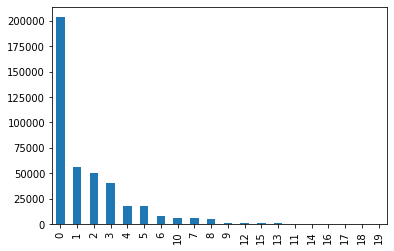

color


/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54844 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54633 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49353 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 55152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44040 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backe

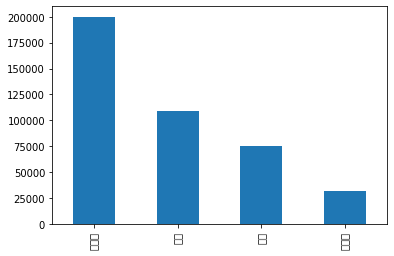

species


/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48121 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 53076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backe

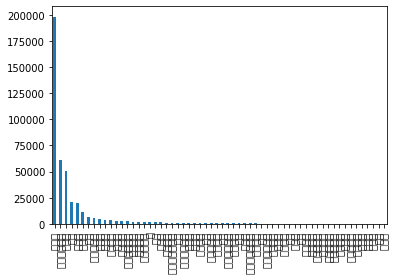

neuteryn


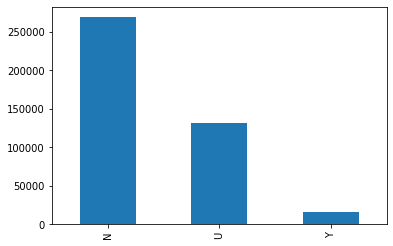

sex


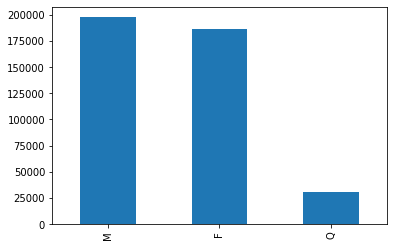

status


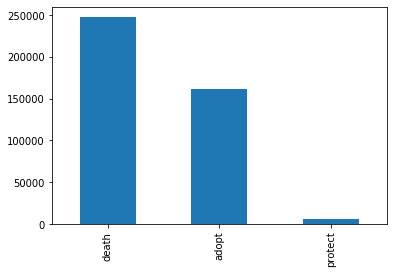

outer_health


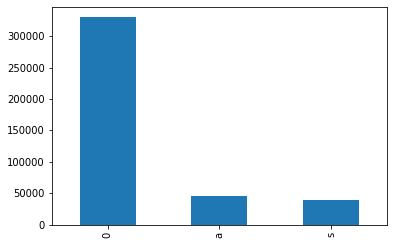

inner_health


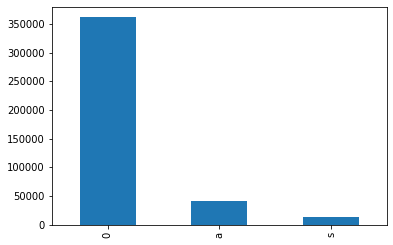

disable


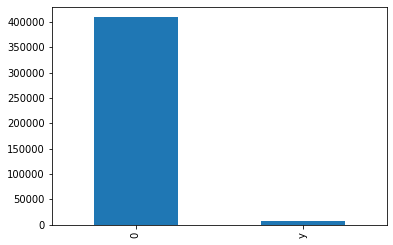

personality


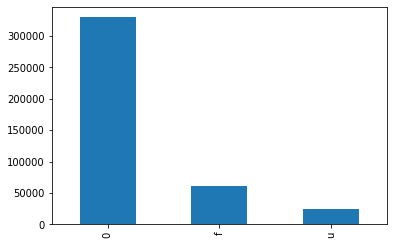

care


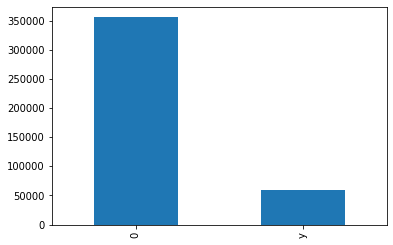

In [12]:
for i in aa.columns:
    print(i)
    aa[i].value_counts().plot(kind = 'bar')
    plt.show()

In [13]:
bb = pd.get_dummies(aa,columns=['color', 'species', 'neuteryn','outer_health','inner_health', 'disable', 'personality', 'care']
                          ,drop_first=True)

bb=pd.get_dummies(bb, columns=['sex'])
bb=bb.drop('sex_Q', axis=1)
#ytest_1 = pd.get_dummies(ytest, drop_first = True)

In [14]:
#객체에 status가 보호중인 index를 저장
drop_adopt = bb[bb['status'] == 'protect'].index


In [15]:
#model data
datas = bb.drop(drop_adopt)

In [16]:
datas['status'].value_counts()

death    247735
adopt    161978
Name: status, dtype: int64

In [17]:
#final check data
pre_set = bb[bb['status'] == 'protect']

In [18]:
y = datas['status']
x = datas.drop('status', axis=1)

## preprocessing

y : adopt=1, others=0

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [20]:
x.shape, y.shape

((409713, 75), (409713,))

In [21]:
y.value_counts()

death    247735
adopt    161978
Name: status, dtype: int64

In [22]:
x.columns, x.shape

(Index(['age', 'color_검은색', 'color_혼합색', 'color_흰색', 'species_닥스훈트',
        'species_달마시안', 'species_도사', 'species_라이카', 'species_러시안블루',
        'species_리트리버', 'species_마리노이즈', 'species_말라뮤트', 'species_말티즈',
        'species_미니어쳐', 'species_미니핀', 'species_믹스견', 'species_믹스묘',
        'species_뱅갈고양이', 'species_베들링턴', 'species_벵갈', 'species_보더콜리',
        'species_보스턴', 'species_브리타니', 'species_브리티시', 'species_비글',
        'species_비숑', 'species_빠삐용', 'species_사냥개', 'species_사모예드',
        'species_삽살개', 'species_샤페이', 'species_샴', 'species_쉽독', 'species_슈나우져',
        'species_스코티시폴드', 'species_스피츠', 'species_시바', 'species_시베리아허스키',
        'species_시츄', 'species_아메리칸숏헤어', 'species_아비시니안', 'species_아키다',
        'species_알라스칸', 'species_요크셔', 'species_웰시', 'species_재패니즈친',
        'species_저먼', 'species_젝러셀테리어', 'species_진돗개', 'species_차우차우',
        'species_치와와', 'species_코리안숏헤어', 'species_코카스파니엘', 'species_터키쉬앙고라',
        'species_퍼그', 'species_페르시안', 'species_페키니즈', 'species_포메라

In [23]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y, test_size=0.3)

In [24]:
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((286799, 75), (286799,), (122914, 75), (122914,))

## Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import metrics

In [26]:
logis = LogisticRegression()

In [27]:
# grid_values = {'C': [0.001,0.01,0.1,1,10,100,1000], 'max_iter':[1000, 2000, 3000, 5000]}
# gscv = GridSearchCV(logis, param_grid=grid_values, return_train_score=True)

In [28]:
#gscv.fit(xtrain, ytrain)

In [29]:
#gscv.best_params_, gscv.best_index_, gscv.best_score_, gscv.best_estimator_

In [30]:
#Logis1 = gscv.best_estimator_

In [31]:
logis.fit(xtrain,ytrain)

/home/sundooedu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
prediction = logis.predict(xtest)

In [33]:
print(classification_report(ytest, prediction))

              precision    recall  f1-score   support

       adopt       0.67      0.40      0.50     48524
       death       0.69      0.87      0.77     74390

    accuracy                           0.69    122914
   macro avg       0.68      0.64      0.64    122914
weighted avg       0.68      0.69      0.66    122914



In [34]:
accuracy_score(ytest,prediction)

0.6854548708853344

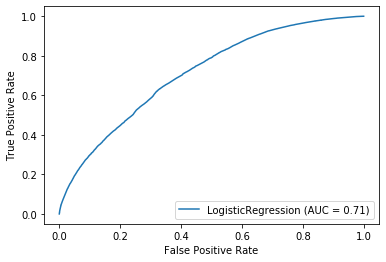

In [35]:
metrics.plot_roc_curve(logis,xtest, ytest)

## Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rdf = RandomForestClassifier(n_estimators=100)

In [38]:
params_rdf = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

In [39]:
#gscv2 = GridSearchCV(rdf, param_grid=params_rdf, return_train_score=True)

In [40]:
#gscv2.fit(xtrain,ytrain)

In [41]:
rdf.fit(xtrain,ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [42]:
#gscv2.best_params_, gscv2.best_score_ ,gscv2.best_estimator_

In [43]:
#rdf1 = gscv2.best_estimator_

In [44]:
#rdf1.fit(xtrain,ytrain)

In [45]:
pred_rdf= rdf.predict(xtest)

In [46]:
accuracy_score(ytest,pred_rdf)

0.6860569178449973

## Perceptron

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [48]:
ytrain.value_counts()

death    173345
adopt    113454
Name: status, dtype: int64

In [49]:
ytrain_p = pd.get_dummies(ytrain)
ytrain_p = ytrain_p.drop(['death'], axis=1)
ytest_p = pd.get_dummies(ytest)
ytest_p = ytest_p.drop(['death'], axis=1)

In [50]:
ytrain_p

,adopt
259145,0
306605,1
376383,1
82787,0
210516,1
...,...
257227,0
276904,1
240808,0
117797,0


In [51]:
model = tf.keras.Sequential()

In [52]:
model.add(layers.Input(xtrain.shape[1]))
model.add(layers.Dense(112, activation='relu'))
model.add(layers.Dense(50 , activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [53]:
early_stopp = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,
restore_best_weights=True)

In [54]:
model.compile(optimizer='ADAM', loss='binary_crossentropy', metrics='accuracy')

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 112)               8512      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5650      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 14,213
Trainable params: 14,213
Non-trainable params: 0
_________________________________________________________________


In [56]:
hist = model.fit(xtrain, ytrain_p, epochs=30, batch_size=500, validation_split = 0.2)

Epoch 1/30
459/459 [==============================] - 1s 2ms/step - loss: 0.5955 - accuracy: 0.6841 - val_loss: 0.5841 - val_accuracy: 0.6937
Epoch 2/30
459/459 [==============================] - 1s 2ms/step - loss: 0.5866 - accuracy: 0.6931 - val_loss: 0.5840 - val_accuracy: 0.6933
Epoch 3/30
459/459 [==============================] - 1s 2ms/step - loss: 0.5854 - accuracy: 0.6940 - val_loss: 0.5837 - val_accuracy: 0.6937
Epoch 4/30
459/459 [==============================] - 1s 2ms/step - loss: 0.5845 - accuracy: 0.6941 - val_loss: 0.5836 - val_accuracy: 0.6930
Epoch 5/30
459/459 [==============================] - 1s 2ms/step - loss: 0.5839 - accuracy: 0.6944 - val_loss: 0.5851 - val_accuracy: 0.6928
Epoch 6/30
459/459 [==============================] - 1s 2ms/step - loss: 0.5835 - accuracy: 0.6945 - val_loss: 0.5820 - val_accuracy: 0.6951
Epoch 7/30
459/459 [==============================] - 1s 2ms/step - loss: 0.5832 - accuracy: 0.6950 - val_loss: 0.5832 - val_accuracy: 0.6941
Epoch 

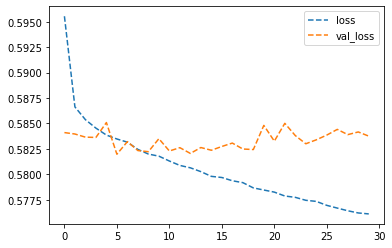

In [57]:
plt.plot(hist.history['loss'], '--', label='loss')
plt.plot(hist.history['val_loss'], '--', label='val_loss')
plt.legend()

In [58]:
ytrain.value_counts(), ytest.value_counts()

(death    173345
 adopt    113454
 Name: status, dtype: int64,
 death    74390
 adopt    48524
 Name: status, dtype: int64)

In [59]:
pre_perc = model.predict(xtest)

In [60]:
result = np.where(pre_perc>=0.5,1,0)

In [61]:
print(classification_report(ytest_p, result))

              precision    recall  f1-score   support

           0       0.70      0.87      0.77     74390
           1       0.68      0.42      0.52     48524

    accuracy                           0.69    122914
   macro avg       0.69      0.65      0.65    122914
weighted avg       0.69      0.69      0.67    122914



## save

In [62]:
import pickle

In [63]:
pickle.dump(logis,open('logis.pkl','wb'))
pickle.dump(rdf,open('rdf1.pkl','wb'))

In [64]:
#aaa = pickle.load(open('logis.pkl','rb'))

In [65]:
model.save('permodel.h5')

## Load

In [66]:
newpic = pickle.load(open('logis.pkl','rb'))

In [67]:
pre_set

,age,status,color_검은색,color_혼합색,color_흰색,species_닥스훈트,species_달마시안,species_도사,species_라이카,species_러시안블루,...,outer_health_a,outer_health_s,inner_health_a,inner_health_s,disable_y,personality_f,personality_u,care_y,sex_F,sex_M
0,0,protect,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,protect,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,protect,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
9,0,protect,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
11,2,protect,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415251,0,protect,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
415252,3,protect,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
415253,9,protect,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
415254,0,protect,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [68]:
pre_y = pre_set['status']
pre_x = pre_set.drop('status', axis=1)

In [69]:
pre_x.shape, pre_y.shape

((5545, 75), (5545,))

In [70]:
pre_result = newpic.predict(pre_x)

In [71]:
pre_result

array(['death', 'adopt', 'adopt', ..., 'adopt', 'death', 'death'],
      dtype=object)

In [72]:
newpic1 = pickle.load(open('rdf1.pkl','rb'))

In [73]:
newpic1.predict(pre_x)

array(['adopt', 'adopt', 'adopt', ..., 'adopt', 'death', 'death'],
      dtype=object)